setting up the framework to develop and backtest algorithms

## Basic strategies to implement

### Simple moving averages (SMA)
when the moving average over a longer period of time crosses the moving average over a shorter period of time, that's our indicator.

### momentum
recent performance been up in the last say 4 days then it'll probably be up today also

### mean reversion
if sotck is above/below the mean it'll probably revert and approach the mean/moving average


# Vectorized Implementation
we will make some predetermined simplifications so that i have more focus on the practice of vectorization

### simple trading strategies
vectorized backtesting has limitations when it comes to backtesting, however, simple strategies can be tested well

### interactive strategy exploration
this vectorized backtesting allows for us to quickly explore trading strategies and their characteristics, parameters can then also be swapped out

### visualization as a goal
this approach lends itself well to being able to create visualizations of the data we are working with

### also it's fast!

# Momentum Based Strategy

two major ideas in this approach

## Cross-sectional momentum strategies
the ides here is to buy instruments that outperform and short/sell instruments underperform: relative to their peers (or some other benchmark)
idea is for 3-12 month holding periods

## time series approach
buy instruments that have recently performed well and sell those that have recently performed poorly
- for this approach the benchmark is the past performance of the instrument

"if it went up yesterday it will probably go up today"

In [7]:
import pandas as pd
import numpy as np

raw = pd.read_csv("data/aiif_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna()

raw.head()


,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


In [8]:
data = pd.DataFrame(raw["XAU="]) # price of gold in USD
data.rename(columns={"XAU=": "price"}, inplace=True)
data.head()

,price
Date,
2010-01-04,1120.00
2010-01-05,1118.65
2010-01-06,1138.50
2010-01-07,1131.90
2010-01-08,1136.10


In [12]:
data['returns'] = np.log(data['price'] / data['price'].shift(1)) # log returns of current / previous price
# taking the log of this will now be negative if < 1

so the simple implementation of this will be to buy if the last return was positive and sell if the last return was negative

In [17]:
from pylab import plt, mpl

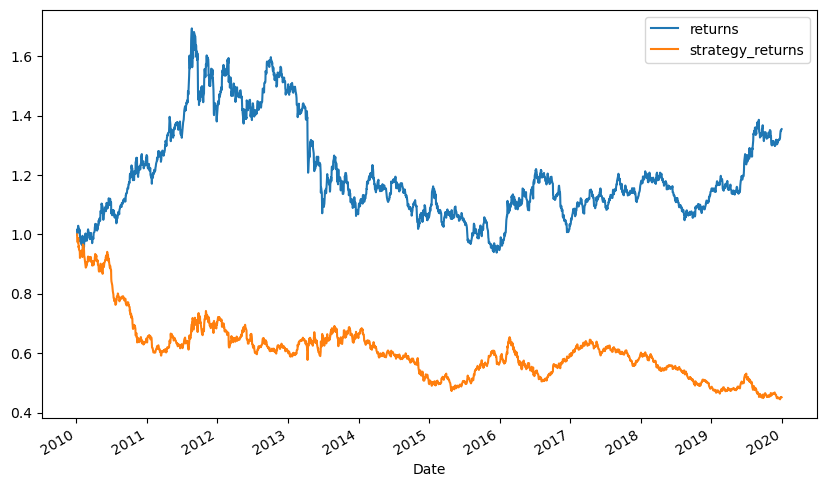

In [19]:
data["position"] = np.sign(data["returns"]) # 1 if positive, -1 if negative
data.fillna({"position": 0}, inplace=True) # fill NaN with 0

data["strategy_returns"] =  data['position'].shift(1) * data['returns']

data[['returns', "strategy_returns"]].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.show()

we underperformed considerably... let's adjust to use a rolling mean instead of single day returns

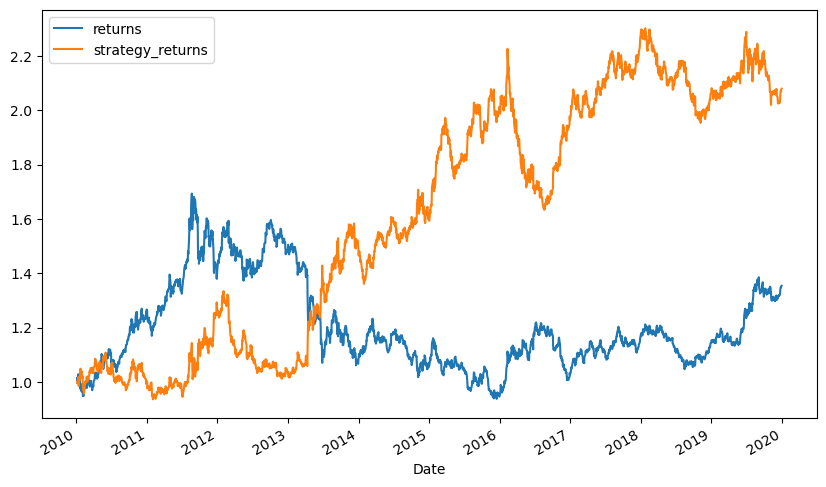

In [44]:
data["position"] = np.sign(data["returns"].rolling(3).mean()) # 1 if positive, -1 if negative
data.fillna({"position": 0}, inplace=True) # fill NaN with 0
data["strategy_returns"] =  data['position'].shift(1) * data['returns']
data[['returns', "strategy_returns"]].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.show()

this performance is very dependent on the number of days that we look at. If we think about it, we would expect this strategy to work better intraday (within a single day) than over multiple days

I'm noticing that this is more volatile than the actual returns, wonder if we can combine the two simple strategies that we just created

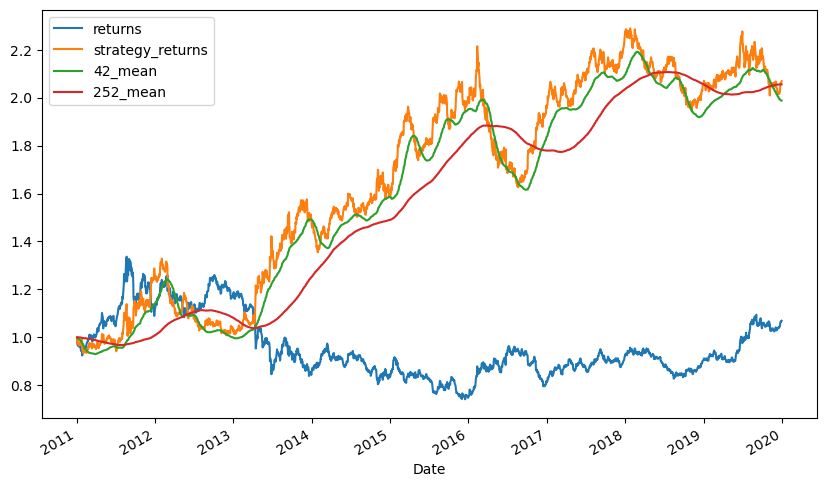

In [45]:
data["252_mean"] = data["strategy_returns"].rolling(252).mean()
data["42_mean"] = data["strategy_returns"].rolling(42).mean()

data[["returns", "strategy_returns", "42_mean", "252_mean"]].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.show()

okay so the momentum backtesting class

In [46]:
from Mom_strategy import MomVectorBacktester

this class is a little different than the last one,

- symbol
- start
- end
- initial amount invested
- transaction cost per trade

it's interesting to include the transaction cost per trade as these momentum strategies and algorithmic strategies in general have a tendency to make a large ammount of trades. in reality the brokers will be charging a certain amount for these trades. 

/opt/notebooks/Mom_strategy.py:75: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["strategy"][trades] -= self.tc


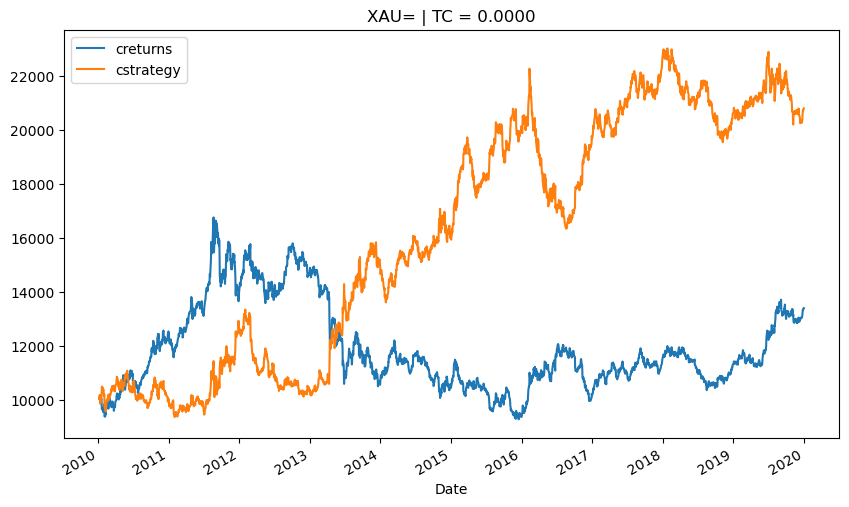

In [49]:
mombt = MomVectorBacktester("XAU=", "2010-1-1", "2019-12-31", 10_000, 0.0) # $10,000 initial 0% transaction cost
mombt.run_strategy(momentum=3)
mombt.plot_results()

same as before, now let's try with a small transaction cost of 0.1%

/opt/notebooks/Mom_strategy.py:75: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["strategy"][trades] -= self.tc


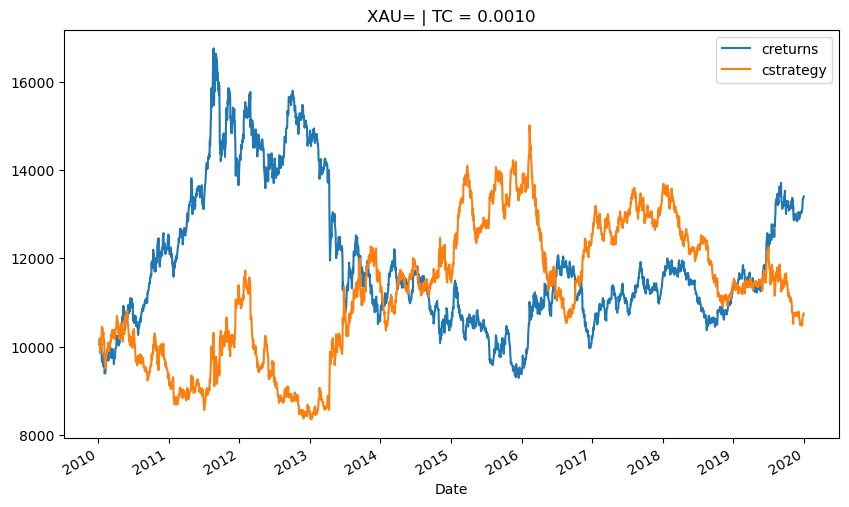

In [51]:
mombt = MomVectorBacktester('XAU=', '2010-1-1','2019-12-31', 10000, 0.001)
mombt.run_strategy(momentum=3)
mombt.plot_results()

evidently even a small transaction cost deteriorates performance. this strategy relies an a large amount of trades which is unsustainable in reality